# Testing data analysis scripts of a run

In case you only have the h5 files and not the .json

In [1]:
%matplotlib notebook
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from escape.parse import swissfel
import h5py
from jungfrau_utils import apply_gain_pede, apply_geometry
h5py.enable_ipython_completer()
import time
import sys

In [2]:
sys.path.insert(0, '../src/')
from data_analysis import *
from integrators import *

In [3]:
n_shots = 2000
run = '0010_jet10um_RT'
path = '/sf/bernina/data/p17743/res/scan_info/'
# load data                                                                         
file_path = '%srun%s.json'%(path,run)
print('-- Loading data:%s'%file_path)
data = swissfel.parseScanEco_v01(file_path,createEscArrays=True,memlimit_mD_MB=50)
jf7 = data['JF07T32V01'] # JungFrau data                                            
total_shots = jf7.data.shape[jf7.eventDim]
if (n_shots>total_shots) or (n_shots==0):
    n_shots = total_shots
print('-- JungFrau 16 Mpix detector contains %d shots - analyzing %d shots' % (total_shots, n_shots))

-- Loading data:/sf/bernina/data/p17743/res/scan_info/run0010_jet10um_RT.json
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 0
Found empty dataset in SARES20-PROF142-M3:FPICTURE in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 0
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH4:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH5:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH6:2 in cycle 1
Found empty dataset in SLAAR21-LSCP1-LAS6991:CH7:2 in cycle 1
Found empty dataset in SARES20-PROF142-M3:FPICTURE in cycle 1
No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension eventDim defined,                    assuming 0th Dimension.
No event dimension eventDim defined,                    assumi

In [4]:
print('-- Loading corrections')
with h5py.File('/sf/bernina/config/jungfrau/gainMaps/JF07T32V01/gains.h5','r') as f:
    gains = f['gains'].value
with h5py.File('/sf/bernina/data/p17743/res/waterJet_tests/JFpedestal/pedestal_20190125_1507.JF07T32V01.res.h5','r') as f:
    pede = f['gains'].value
with h5py.File('/sf/bernina/data/p17743/res/JF_pedestals/pedestal_20190115_1551.JF07T32V01.res.h5','r') as f:
    noise = f['gainsRMS'].value
    mask = f['pixel_mask'].value

-- Loading corrections


In [5]:
t1 = time.time()
icorr = apply_gain_pede(jf7.data[0].compute(),G=gains, P=pede, pixel_mask=mask)
icorr_geom = apply_geometry(icorr,'JF07T32V01')
mask_geom = ~apply_geometry(~(mask>0),'JF07T32V01')
icorr_geom[mask_geom] = 0 #np.nan
avg_img_even = np.zeros_like(icorr_geom)
avg_img_odd = np.zeros_like(icorr_geom)
mask_inv = np.logical_not(mask_geom) #inversed: 0 masked, 1 not masked  
iq_threshold = 4.
hits_even = 0
hits_odd = 0

# initialise for angular integration                                        
rad_dist = radial_distances(icorr_geom)
ra = RadialAverager(rad_dist, mask_inv)
r  = ra.bin_centers
iq = ra(icorr_geom)
iqs = np.zeros((n_shots, iq.shape[0]))
iqs[0] = iq
print('s.%i, %.1f Hz: %.2f photon/pix' % (1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5)))

for i in range(1,n_shots):
    t1 = time.time()
    icorr = apply_gain_pede(jf7.data[i].compute(),G=gains, P=pede, pixel_mask=mask)
    icorr_geom = apply_geometry(icorr,'JF07T32V01')
    icorr_geom[mask_geom] = 0
    iq = ra(icorr_geom)
    iqs[i] = iq
    if iq[5:80].mean() > iq_threshold:
        if (i % 2) == 0:
            avg_img_even += icorr_geom
            hits_even += 1
            print('s.%i, %.1f Hz: %.2f photon/pix: EVEN HIT' % (i+1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5)))
        else:
            avg_img_odd += icorr_geom
            hits_odd += 1
            print('s.%i, %.1f Hz: %.2f photon/pix: ODD HIT' % (i+1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5)))
    else:
        print('s.%i, %.1f Hz: %.2f photon/pix' % (i+1, 1.0/(time.time() - t1), np.mean(icorr_geom[mask_inv]/9.5)))
avg_img_even /= hits_even
avg_img_odd /= hits_odd
print('-- DONE! even: %d hits, odd: %d hits, total hitrate: %.1f%%' % (hits_even, hits_odd, 100*(hits_even+hits_odd)/n_shots))

s.1, 0.5 Hz: 0.37 photon/pix
s.2, 1.7 Hz: 0.15 photon/pix
s.3, 1.8 Hz: 0.50 photon/pix: EVEN HIT
s.4, 2.4 Hz: 0.17 photon/pix
s.5, 2.4 Hz: 0.17 photon/pix
s.6, 2.3 Hz: 0.18 photon/pix
s.7, 2.4 Hz: 0.18 photon/pix
s.8, 2.4 Hz: 0.16 photon/pix
s.9, 2.3 Hz: 0.17 photon/pix
s.10, 2.3 Hz: 0.18 photon/pix
s.11, 2.3 Hz: 0.13 photon/pix
s.12, 2.3 Hz: 0.19 photon/pix
s.13, 2.3 Hz: 0.18 photon/pix
s.14, 2.4 Hz: 0.17 photon/pix
s.15, 2.4 Hz: 0.17 photon/pix
s.16, 2.4 Hz: 0.17 photon/pix
s.17, 2.3 Hz: 0.35 photon/pix: EVEN HIT
s.18, 2.3 Hz: 0.38 photon/pix: ODD HIT
s.19, 2.3 Hz: 0.16 photon/pix
s.20, 2.3 Hz: 0.18 photon/pix
s.21, 2.3 Hz: 0.15 photon/pix
s.22, 2.3 Hz: 0.18 photon/pix
s.23, 2.3 Hz: 0.16 photon/pix
s.24, 2.2 Hz: 0.32 photon/pix: ODD HIT
s.25, 2.2 Hz: 0.32 photon/pix: EVEN HIT
s.26, 2.3 Hz: 0.16 photon/pix
s.27, 2.2 Hz: 0.39 photon/pix: EVEN HIT
s.28, 2.2 Hz: 0.38 photon/pix: ODD HIT
s.29, 2.3 Hz: 0.18 photon/pix
s.30, 2.3 Hz: 0.16 photon/pix
s.31, 2.3 Hz: 0.23 photon/pix
s.32, 2.3 Hz

s.257, 2.4 Hz: 0.19 photon/pix
s.258, 2.3 Hz: 0.15 photon/pix
s.259, 2.3 Hz: 0.19 photon/pix
s.260, 2.3 Hz: 0.19 photon/pix
s.261, 2.4 Hz: 0.18 photon/pix
s.262, 2.3 Hz: 0.17 photon/pix
s.263, 2.2 Hz: 0.26 photon/pix: EVEN HIT
s.264, 2.3 Hz: 0.17 photon/pix
s.265, 2.3 Hz: 0.18 photon/pix
s.266, 2.3 Hz: 0.18 photon/pix
s.267, 2.3 Hz: 0.17 photon/pix
s.268, 2.2 Hz: 0.25 photon/pix: ODD HIT
s.269, 2.3 Hz: 0.17 photon/pix
s.270, 2.3 Hz: 0.15 photon/pix
s.271, 2.4 Hz: 0.11 photon/pix
s.272, 2.4 Hz: 0.11 photon/pix
s.273, 2.3 Hz: 0.28 photon/pix
s.274, 2.3 Hz: 0.14 photon/pix
s.275, 2.3 Hz: 0.16 photon/pix
s.276, 2.4 Hz: 0.14 photon/pix
s.277, 2.4 Hz: 0.19 photon/pix
s.278, 2.4 Hz: 0.18 photon/pix
s.279, 2.4 Hz: 0.34 photon/pix: EVEN HIT
s.280, 2.4 Hz: 0.16 photon/pix
s.281, 2.4 Hz: 0.16 photon/pix
s.282, 2.3 Hz: 0.20 photon/pix
s.283, 2.3 Hz: 0.19 photon/pix
s.284, 2.4 Hz: 0.15 photon/pix
s.285, 2.3 Hz: 0.17 photon/pix
s.286, 2.2 Hz: 0.29 photon/pix: ODD HIT
s.287, 2.3 Hz: 0.15 photon/pix
s

s.512, 2.4 Hz: 0.26 photon/pix
s.513, 2.2 Hz: 0.15 photon/pix
s.514, 2.3 Hz: 0.14 photon/pix
s.515, 2.4 Hz: 0.16 photon/pix
s.516, 2.4 Hz: 0.15 photon/pix
s.517, 2.3 Hz: 0.14 photon/pix
s.518, 2.3 Hz: 0.18 photon/pix
s.519, 2.3 Hz: 0.18 photon/pix
s.520, 2.4 Hz: 0.19 photon/pix
s.521, 2.4 Hz: 0.16 photon/pix
s.522, 2.2 Hz: 0.20 photon/pix
s.523, 2.3 Hz: 0.14 photon/pix
s.524, 2.3 Hz: 0.13 photon/pix
s.525, 2.2 Hz: 0.45 photon/pix: EVEN HIT
s.526, 2.2 Hz: 0.28 photon/pix: ODD HIT
s.527, 2.3 Hz: 0.17 photon/pix
s.528, 2.3 Hz: 0.23 photon/pix
s.529, 2.3 Hz: 0.16 photon/pix
s.530, 2.2 Hz: 0.12 photon/pix
s.531, 2.2 Hz: 0.17 photon/pix
s.532, 2.3 Hz: 0.15 photon/pix
s.533, 2.3 Hz: 0.16 photon/pix
s.534, 2.3 Hz: 0.18 photon/pix
s.535, 2.2 Hz: 0.45 photon/pix: EVEN HIT
s.536, 2.3 Hz: 0.16 photon/pix
s.537, 2.3 Hz: 0.17 photon/pix
s.538, 2.3 Hz: 0.18 photon/pix
s.539, 2.3 Hz: 0.15 photon/pix
s.540, 2.2 Hz: 0.35 photon/pix: ODD HIT
s.541, 2.4 Hz: 0.19 photon/pix
s.542, 2.3 Hz: 0.18 photon/pix
s

s.767, 2.2 Hz: 0.16 photon/pix
s.768, 2.3 Hz: 0.36 photon/pix: ODD HIT
s.769, 2.3 Hz: 0.18 photon/pix
s.770, 2.3 Hz: 0.17 photon/pix
s.771, 2.3 Hz: 0.18 photon/pix
s.772, 2.3 Hz: 0.17 photon/pix
s.773, 2.3 Hz: 0.19 photon/pix
s.774, 2.3 Hz: 0.17 photon/pix
s.775, 2.2 Hz: 0.18 photon/pix
s.776, 2.3 Hz: 0.16 photon/pix
s.777, 2.2 Hz: 0.33 photon/pix: EVEN HIT
s.778, 2.3 Hz: 0.14 photon/pix
s.779, 2.3 Hz: 0.25 photon/pix
s.780, 2.3 Hz: 0.15 photon/pix
s.781, 2.3 Hz: 0.16 photon/pix
s.782, 2.3 Hz: 0.17 photon/pix
s.783, 2.3 Hz: 0.16 photon/pix
s.784, 2.4 Hz: 0.13 photon/pix
s.785, 2.3 Hz: 0.35 photon/pix: EVEN HIT
s.786, 2.3 Hz: 0.16 photon/pix
s.787, 2.4 Hz: 0.16 photon/pix
s.788, 2.3 Hz: 0.15 photon/pix
s.789, 2.2 Hz: 0.15 photon/pix
s.790, 2.3 Hz: 0.13 photon/pix
s.791, 2.3 Hz: 0.44 photon/pix: EVEN HIT
s.792, 2.4 Hz: 0.17 photon/pix
s.793, 2.2 Hz: 0.37 photon/pix: EVEN HIT
s.794, 2.4 Hz: 0.17 photon/pix
s.795, 2.4 Hz: 0.15 photon/pix
s.796, 2.4 Hz: 0.17 photon/pix
s.797, 2.4 Hz: 0.16 p

s.1023, 2.3 Hz: 0.13 photon/pix
s.1024, 2.3 Hz: 0.14 photon/pix
s.1025, 2.3 Hz: 0.15 photon/pix
s.1026, 2.2 Hz: 0.31 photon/pix: ODD HIT
s.1027, 2.3 Hz: 0.18 photon/pix
s.1028, 2.3 Hz: 0.17 photon/pix
s.1029, 2.3 Hz: 0.16 photon/pix
s.1030, 2.3 Hz: 0.20 photon/pix
s.1031, 2.3 Hz: 0.17 photon/pix
s.1032, 2.2 Hz: 0.38 photon/pix: ODD HIT
s.1033, 2.2 Hz: 0.39 photon/pix: EVEN HIT
s.1034, 2.3 Hz: 0.19 photon/pix
s.1035, 2.4 Hz: 0.17 photon/pix
s.1036, 2.3 Hz: 0.36 photon/pix: ODD HIT
s.1037, 2.4 Hz: 0.16 photon/pix
s.1038, 2.4 Hz: 0.15 photon/pix
s.1039, 2.3 Hz: 0.16 photon/pix
s.1040, 2.3 Hz: 0.15 photon/pix
s.1041, 2.4 Hz: 0.18 photon/pix
s.1042, 2.3 Hz: 0.16 photon/pix
s.1043, 2.4 Hz: 0.14 photon/pix
s.1044, 2.3 Hz: 0.30 photon/pix: ODD HIT
s.1045, 2.4 Hz: 0.16 photon/pix
s.1046, 2.3 Hz: 0.34 photon/pix: ODD HIT
s.1047, 2.3 Hz: 0.15 photon/pix
s.1048, 2.3 Hz: 0.18 photon/pix
s.1049, 2.3 Hz: 0.13 photon/pix
s.1050, 2.4 Hz: 0.13 photon/pix
s.1051, 2.3 Hz: 0.15 photon/pix
s.1052, 2.3 Hz: 0

s.1267, 2.3 Hz: 0.17 photon/pix
s.1268, 2.3 Hz: 0.18 photon/pix
s.1269, 2.4 Hz: 0.18 photon/pix
s.1270, 2.3 Hz: 0.15 photon/pix
s.1271, 2.4 Hz: 0.17 photon/pix
s.1272, 2.2 Hz: 0.17 photon/pix
s.1273, 2.2 Hz: 0.38 photon/pix: EVEN HIT
s.1274, 2.3 Hz: 0.17 photon/pix
s.1275, 2.4 Hz: 0.16 photon/pix
s.1276, 2.4 Hz: 0.17 photon/pix
s.1277, 2.3 Hz: 0.16 photon/pix
s.1278, 2.4 Hz: 0.15 photon/pix
s.1279, 2.2 Hz: 0.38 photon/pix: EVEN HIT
s.1280, 2.3 Hz: 0.11 photon/pix
s.1281, 2.3 Hz: 0.16 photon/pix
s.1282, 2.3 Hz: 0.14 photon/pix
s.1283, 2.3 Hz: 0.13 photon/pix
s.1284, 2.4 Hz: 0.13 photon/pix
s.1285, 2.3 Hz: 0.17 photon/pix
s.1286, 2.3 Hz: 0.18 photon/pix
s.1287, 2.3 Hz: 0.39 photon/pix: EVEN HIT
s.1288, 2.3 Hz: 0.17 photon/pix
s.1289, 2.2 Hz: 0.27 photon/pix: EVEN HIT
s.1290, 2.3 Hz: 0.12 photon/pix
s.1291, 2.4 Hz: 0.10 photon/pix
s.1292, 2.4 Hz: 0.15 photon/pix
s.1293, 2.3 Hz: 0.18 photon/pix
s.1294, 2.3 Hz: 0.16 photon/pix
s.1295, 2.2 Hz: 0.31 photon/pix: EVEN HIT
s.1296, 2.3 Hz: 0.14 p

s.1511, 2.4 Hz: 0.17 photon/pix
s.1512, 2.2 Hz: 0.28 photon/pix: ODD HIT
s.1513, 2.3 Hz: 0.17 photon/pix
s.1514, 2.3 Hz: 0.14 photon/pix
s.1515, 2.2 Hz: 0.33 photon/pix: EVEN HIT
s.1516, 2.2 Hz: 0.39 photon/pix: ODD HIT
s.1517, 2.3 Hz: 0.18 photon/pix
s.1518, 2.2 Hz: 0.17 photon/pix
s.1519, 2.3 Hz: 0.19 photon/pix
s.1520, 2.4 Hz: 0.18 photon/pix
s.1521, 2.3 Hz: 0.16 photon/pix
s.1522, 2.3 Hz: 0.16 photon/pix
s.1523, 2.3 Hz: 0.18 photon/pix
s.1524, 2.2 Hz: 0.15 photon/pix
s.1525, 2.2 Hz: 0.18 photon/pix
s.1526, 2.3 Hz: 0.16 photon/pix
s.1527, 2.2 Hz: 0.15 photon/pix
s.1528, 2.3 Hz: 0.15 photon/pix
s.1529, 2.3 Hz: 0.19 photon/pix
s.1530, 2.2 Hz: 0.18 photon/pix
s.1531, 2.3 Hz: 0.18 photon/pix
s.1532, 2.3 Hz: 0.15 photon/pix
s.1533, 2.3 Hz: 0.15 photon/pix
s.1534, 2.3 Hz: 0.18 photon/pix
s.1535, 2.3 Hz: 0.17 photon/pix
s.1536, 2.2 Hz: 0.22 photon/pix
s.1537, 2.2 Hz: 0.12 photon/pix
s.1538, 2.2 Hz: 0.33 photon/pix: ODD HIT
s.1539, 2.3 Hz: 0.15 photon/pix
s.1540, 2.3 Hz: 0.17 photon/pix
s.1

s.1757, 2.3 Hz: 0.17 photon/pix
s.1758, 2.2 Hz: 0.16 photon/pix
s.1759, 2.3 Hz: 0.15 photon/pix
s.1760, 2.3 Hz: 0.15 photon/pix
s.1761, 2.2 Hz: 0.17 photon/pix
s.1762, 2.3 Hz: 0.16 photon/pix
s.1763, 2.3 Hz: 0.26 photon/pix
s.1764, 2.2 Hz: 0.37 photon/pix: ODD HIT
s.1765, 2.3 Hz: 0.17 photon/pix
s.1766, 2.3 Hz: 0.12 photon/pix
s.1767, 2.2 Hz: 0.36 photon/pix: EVEN HIT
s.1768, 2.3 Hz: 0.12 photon/pix
s.1769, 2.3 Hz: 0.14 photon/pix
s.1770, 2.3 Hz: 0.39 photon/pix: ODD HIT
s.1771, 2.3 Hz: 0.16 photon/pix
s.1772, 2.2 Hz: 0.38 photon/pix: ODD HIT
s.1773, 2.3 Hz: 0.15 photon/pix
s.1774, 2.3 Hz: 0.20 photon/pix
s.1775, 2.2 Hz: 0.26 photon/pix: EVEN HIT
s.1776, 2.3 Hz: 0.18 photon/pix
s.1777, 2.3 Hz: 0.18 photon/pix
s.1778, 2.3 Hz: 0.18 photon/pix
s.1779, 2.2 Hz: 0.33 photon/pix: EVEN HIT
s.1780, 2.2 Hz: 0.16 photon/pix
s.1781, 2.3 Hz: 0.15 photon/pix
s.1782, 2.3 Hz: 0.12 photon/pix
s.1783, 2.4 Hz: 0.21 photon/pix
s.1784, 2.4 Hz: 0.14 photon/pix
s.1785, 2.3 Hz: 0.15 photon/pix
s.1786, 2.3 Hz:

s.1999, 2.2 Hz: 0.32 photon/pix: EVEN HIT
s.2000, 2.3 Hz: 0.17 photon/pix
-- DONE! even: 153 hits, odd: 145 hits, total hitrate: 14.9%


<IPython.core.display.Javascript object>


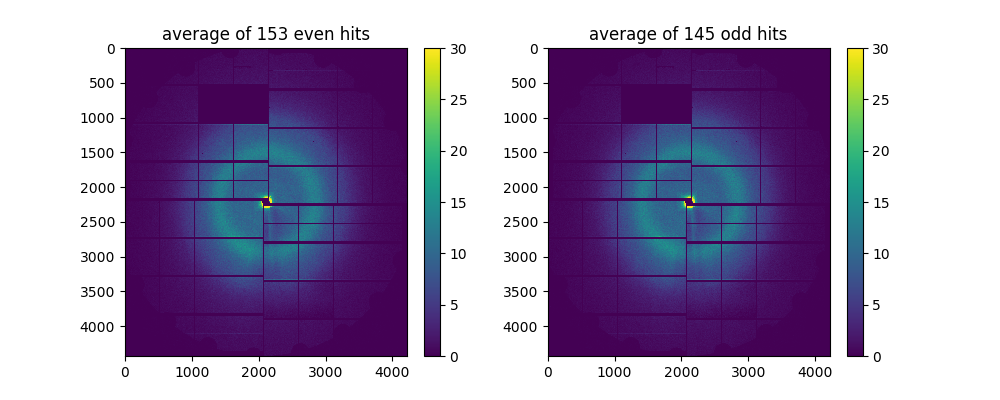

In [6]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.title('average of %d even hits' % hits_even)
plt.imshow(avg_img_even,aspect='auto',clim=[0,30])
plt.colorbar()

plt.subplot(1,2,2)
plt.title('average of %d odd hits' % hits_odd)
plt.imshow(avg_img_odd,aspect='auto',clim=[0,30])
plt.colorbar()

plt.savefig('run%s_2d_hits_even_vs_odd.png' % run)
plt.show()

In [7]:
iq_metric = iqs[:,5:80].mean(axis=1)
bi,bf,db = iq_metric.min(),iq_metric.max(),.5
bins = np.arange(bi-db,bf+db,db)
hy,hx = np.histogram(iq_metric,bins=bins)
bin_centers = np.array([(bins[j]+bins[j+1])/2. for j in range(len(bins)-1)])

<IPython.core.display.Javascript object>


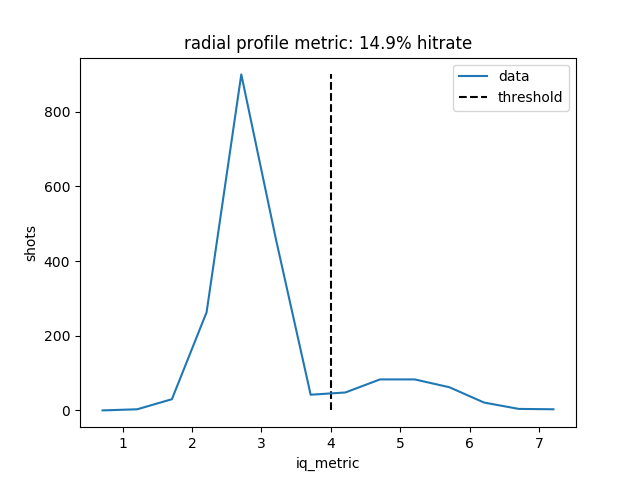

In [8]:
#iq_threshold = 4*4
plt.figure()
plt.title('radial profile metric: %.1f%% hitrate' % (100*(iq_metric > iq_threshold).sum()/n_shots))
plt.plot(bin_centers, hy, label='data')
plt.ylabel('shots')
plt.xlabel('iq_metric')
plt.vlines(iq_threshold,0,hy.max(),color='k',linestyles='dashed',label='threshold')
plt.legend()
plt.savefig('run%s_radial_profile_hist.png' % run)
plt.show()

In [9]:
q = q_scale(r, detector_distance=0.12) # detector_distance=0.127 m according to Alex measurement
iqs_even = iqs[::2]
iqs_odd = iqs[1::2]
iq_avg_even = iqs_even[iq_metric[::2] > iq_threshold].mean(axis=0)
iq_avg_odd = iqs_odd[iq_metric[1::2] > iq_threshold].mean(axis=0)

<IPython.core.display.Javascript object>


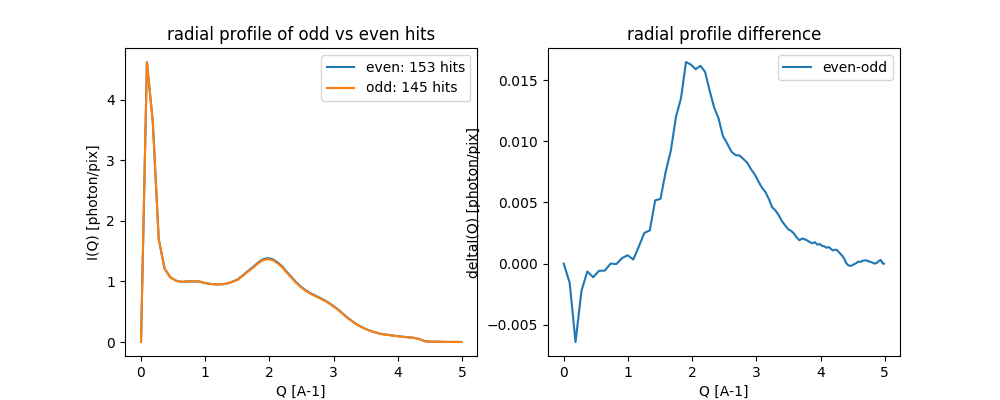

In [11]:
plt.figure(figsize=[10,4])
plt.subplot(1,2,1)
plt.title('radial profile of odd vs even hits')
plt.plot(q, iq_avg_even/9.5, label='even: %d hits' % hits_even)
plt.plot(q, iq_avg_odd/9.5, label='odd: %d hits' % hits_odd)
plt.ylabel('I(Q) [photon/pix]')
plt.xlabel('Q [A-1]')
plt.legend()

plt.subplot(1,2,2)
plt.title('radial profile difference')
plt.plot(q, (iq_avg_even-iq_avg_odd)/9.5, label='even-odd')
plt.ylabel('deltaI(Q) [photon/pix]')
plt.xlabel('Q [A-1]')
plt.legend()

plt.savefig('run%s_radial_profile_even_vs_odd.png' % run)
plt.show()

<IPython.core.display.Javascript object>


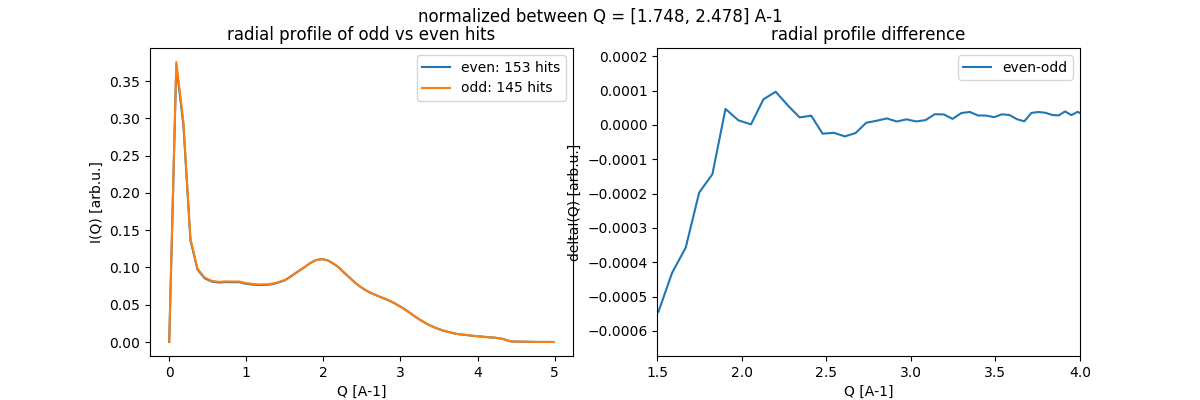

In [22]:
plt.figure(figsize=[12,4])
plt.suptitle('normalized between Q = [%.03f, %.03f] A-1' % (q[20], q[30]))
plt.subplot(1,2,1)
plt.title('radial profile of odd vs even hits')
plt.plot(q, iq_avg_even/iq_avg_even[20:30].sum(), label='even: %d hits' % hits_even)
plt.plot(q, iq_avg_odd/iq_avg_odd[20:30].sum(), label='odd: %d hits' % hits_odd)
plt.ylabel('I(Q) [arb.u.]')
plt.xlabel('Q [A-1]')
plt.legend()

plt.subplot(1,2,2)
plt.title('radial profile difference')
iq_diff_norm = (iq_avg_even/iq_avg_even[20:30].sum()-iq_avg_odd/iq_avg_odd[20:30].sum())
plt.plot(q, iq_diff_norm, label='even-odd')
plt.ylabel('deltaI(Q) [arb.u.]')
plt.xlabel('Q [A-1]')
plt.xlim([1.5,4.0])
plt.ylim([iq_diff_norm[17:60].min() - iq_diff_norm[17:60].std(), iq_diff_norm[17:60].max() + iq_diff_norm[17:60].std()])
plt.legend()
#plt.tight_layout()

plt.savefig('run%s_radial_profile_even_vs_odd_normalized+zoom.png' % run)
plt.show()

In [23]:
q[17:60]

array([ 1.5059681 ,  1.58763582,  1.66823417,  1.7477325 ,  1.8261036 ,
        1.90332363,  1.97937208,  2.0542316 ,  2.12788797,  2.20032989,
        2.27154893,  2.34153931,  2.41029782,  2.47782363,  2.54411813,
        2.60918483,  2.67302916,  2.73565832,  2.79708116,  2.85730804,
        2.91635066,  2.97422194,  3.03093591,  3.08650756,  3.14095275,
        3.19428808,  3.24653081,  3.29769875,  3.34781014,  3.39688365,
        3.44493821,  3.49199299,  3.53806733,  3.58318066,  3.62735248,
        3.67060226,  3.71294944,  3.75441336,  3.79501325,  3.83476817,
        3.87369699,  3.91181839,  3.94915078])